In [1]:
import pandas as pd
import matplotlib.pyplot as plt

INPUT_CSV = "ted_talks_clean.csv"
OUTPUT_CSV = "chunks.csv"

MAX_CHARS_PER_CHUNK = 3000
OVERLAP_SENTENCES   = 2
READ_CHUNKSIZE      = 200



In [2]:
def clean_text_no_regex(s: str) -> str:
  #Very light cleanup using only string ops
    if s is None:
        return ""
    s = str(s)
    # remove a few common bracket tags without regex
    for tag in ["[Applause]", "[Laughter]", "[Music]"]:
        s = s.replace(tag, " ")
    # collapse whitespace
    s = " ".join(s.split())
    return s.strip()

def split_sentences_no_regex(text: str):
    #Split on '.', '?', '!' while keeping the punctuation
    text = text.strip()
    if not text:
        return []
    out, cur = [], []
    for ch in text:
        cur.append(ch)
        if ch in ".!?":             # sentence end
            sent = "".join(cur).strip()
            if sent:
                out.append(sent)
            cur = []
    if cur:  # leftover without terminal punctuation
        last = "".join(cur).strip()
        if last:
            out.append(last)
    return out

In [3]:
def chunk_by_chars_no_regex(text: str, max_chars=3000, overlap_sents=2):
   #Packed whole sentences up to ~max_chars and keep a small overlap
    text = clean_text_no_regex(text)
    sents = split_sentences_no_regex(text)
    if not sents:
        return []

    # compute char starts for each sentence (simple scan)
    idxs, pos = [], 0
    for s in sents:
        start = text.find(s, pos)
        idxs.append(start if start >= 0 else pos)
        pos = (start if start >= 0 else pos) + len(s)

    chunks, buf, buf_start_char, i = [], [], None, 0
    while i < len(sents):
        s = sents[i]
        if not buf:
            buf_start_char = idxs[i]
        candidate = (" ".join(buf + [s])).strip()
        if len(candidate) <= max_chars or not buf:
            buf.append(s); i += 1
        else:
            chunk_text = " ".join(buf).strip()
            start_char = buf_start_char
            end_char = start_char + len(chunk_text)
            chunks.append((start_char, end_char, chunk_text))
            # overlap
            buf = buf[-overlap_sents:] if overlap_sents > 0 else []
            if buf:
                first_overlap = buf[0]
                new_start = text.find(first_overlap, start_char)
                buf_start_char = new_start if new_start >= 0 else end_char - len(" ".join(buf))
            else:
                buf_start_char = None

    if buf:
        chunk_text = " ".join(buf).strip()
        start_char = buf_start_char if buf_start_char is not None else 0
        end_char = start_char + len(chunk_text)
        chunks.append((start_char, end_char, chunk_text))
    return chunks

In [5]:
#  stream input, write chunks 
from pathlib import Path

need_header = not Path(OUTPUT_CSV).exists()
with open(OUTPUT_CSV, "w", encoding="utf-8") as fout:
    fout.write("talk_id,chunk_id,title,speaker,start_char,end_char,n_chars,chunk_text\n")

processed = 0
for batch in pd.read_csv(INPUT_CSV, chunksize=READ_CHUNKSIZE):
    if "talk_id" not in batch.columns:
        batch = batch.reset_index(drop=False).rename(columns={"index":"talk_id"})
    rows = []
    for _, row in batch.iterrows():
        talk_id  = int(row["talk_id"])
        title    = row.get("title", "")
        speaker  = row.get("speaker", row.get("speaker_1", ""))
        transcript = str(row["transcript"])

        pieces = chunk_by_chars_no_regex(transcript, MAX_CHARS_PER_CHUNK, OVERLAP_SENTENCES)
        for idx, (s_char, e_char, txt) in enumerate(pieces):
            if len(txt) < 20:
                continue
            # CSV-safe line (escape quotes by doubling)
            safe = txt.replace('"', '""')
            rows.append(f'{talk_id},{idx},"{title}","{speaker}",{s_char},{e_char},{len(txt)},"{safe}"')
    with open(OUTPUT_CSV, "a", encoding="utf-8") as fout:
        fout.write("\n".join(rows) + ("\n" if rows else ""))
    processed += len(batch)
    print(f"Processed rows: {processed}")

print("Wrote:", OUTPUT_CSV)

Processed rows: 200
Processed rows: 400
Processed rows: 600
Processed rows: 800
Processed rows: 1000
Processed rows: 1200
Processed rows: 1400
Processed rows: 1600
Processed rows: 1800
Processed rows: 2000
Processed rows: 2200
Processed rows: 2400
Processed rows: 2600
Processed rows: 2800
Processed rows: 3000
Processed rows: 3200
Processed rows: 3400
Processed rows: 3600
Processed rows: 3800
Processed rows: 3957
Wrote: chunks.csv


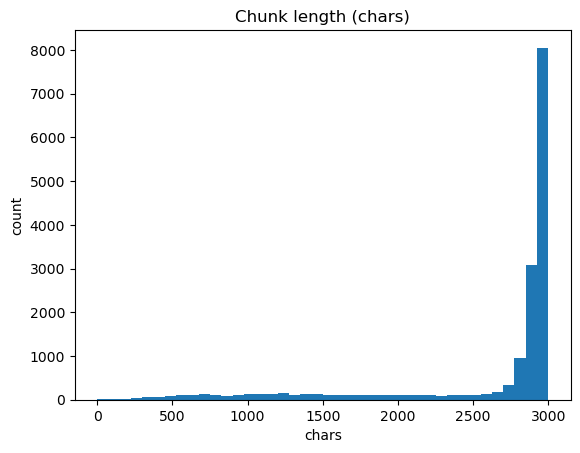

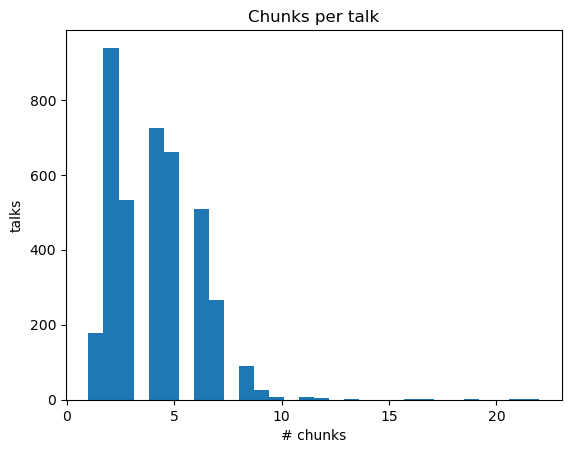

In [6]:
 
mini = pd.read_csv(OUTPUT_CSV, usecols=["talk_id","n_chars"])
plt.figure(); mini["n_chars"].plot(kind="hist", bins=40)
plt.title("Chunk length (chars)"); plt.xlabel("chars"); plt.ylabel("count"); plt.show()

plt.figure(); mini.groupby("talk_id")["n_chars"].count().plot(kind="hist", bins=30)
plt.title("Chunks per talk"); plt.xlabel("# chunks"); plt.ylabel("talks"); plt.show()
